
# ASTR 302 Final Project: Exploring the Characteristics of Binary Star System HD 265435


### Introduction and Motivation
HD 265435 is a short-period binary system composed of a hot subdwarf and a white dwarf. What made this system particularly interesting for our project was its unique tear-drop shape and the distinct light curve it produced. The system's orbital period (~100 minutes) and the presence of tidally tilted pulsations from the hot subdwarf make it an excellent candidate for time-series photometry. This project focused on observing the system using the 61-inch telescope at Mount Bigelow, processing the acquired data through a custom reduction pipeline, and analyzing the resulting light curve. Our goal was to observe the characteristics of pulsating binary systems by creating and analyzing light curves of the relevant oscillations.

In [1]:
# All imports necessary for the ordered code

# Imports introduced in functions.py
import astropy
import photutils
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from astropy.wcs import WCS
import astroalign as aa

# Imports introduced in main.py
import os
import pandas as pd

# Imports introduced in read_phot.py
from scipy.fft import fft, fftfreq

# imports introduced in project_tests.ipynb
import csv
import astrometry
import astropy.units as u
import matplotlib.image as mpimg

from photutils.detection import DAOStarFinder
from astropy.stats import mad_std

from astropy.stats import sigma_clipped_stats
from astropy.stats import SigmaClip

from photutils.background import Background2D, MedianBackground

### Methods and Data Reduction

- Code below is from the Github Repository where we created a pipeline so that we could just run all 629 fits files at once instead of going through it individually. I did not run it after transferring it to Jupyter where I did this write up. As such, some calls for file names may not match due to the fact tehy were the calls when in the Github Repository. Below, there are examples where the calls do match the call functions for my data in Jupyter Lab.

- We conducted observations on February 28, 2025, collecting 629 R-band images with 20-second exposures and approximately 11 seconds of dead time between frames. The data were processed using the following sequence:


In [ ]:
# Function to open and extract data and header from a FITS file

def open_data(fits_num):
    filename = f'Image Data/hd265435.{fits_num}.fits'  # Path format for input FITS images
    hdul = fits.open(filename)[0]                      # Open the primary HDU
    data = hdul.data                                   # Extract the image data array
    header = hdul.header                               # Extract the metadata header
    return data                                        # Return only the data (could also return header if needed)

- **Bias Subtraction and Flat-Fielding:**
The raw CCD images often contain instrumental effects such as bias (zero-level offset) and variations in sensitivity across the detector. The first step was to remove these effects.

    - Bias Subtraction: A bias frame was subtracted from the image to remove the constant offset caused by the detector's electronics.
    - Flat-Fielding: A flat-field image was used to correct for pixel-to-pixel variations in sensitivity. This image was normalized and applied to the raw data to ensure accurate flux measurements by compensating for these variations.
 
      
        - Removed instrumental effects from CCD images.

In [ ]:
# This function removes instrumental effects (bias and pixel sensitivity variations) from CCD images.

def subtract_bias_flat(num):
    data = open_data(num)  # Load raw CCD image using previously defined function

    # Open master bias frame (preprocessed from multiple bias exposures)
    hdul = fits.open(r"/workspaces/HD265436_ASTR302/Bias-Flats/bias.fits")[0]
    bias = hdul.data

    # Open master flat field (already bias-subtracted and combined from flat frames)
    hdul1 = fits.open(r"/workspaces/HD265436_ASTR302/Bias-Flats/rflat.fits")[0]
    flat = hdul1.data

    # Avoid division by zero during flat-fielding by setting flat pixels with value 0 to 1
    for i in range(1476):
        for j in range(2048):
            if flat[i][j] == 0:
                flat[i][j] = 1

    # Normalize the flat field by its average value to ensure uniform scaling
    av = np.mean(flat)
    averaged_flat = (flat / av)
    norm_flat = averaged_flat / np.mean(averaged_flat)

    # Subtract bias from the science image
    sub_image = data - bias

    # Divide by the normalized flat to correct for pixel-to-pixel sensitivity
    image = sub_image / norm_flat

    return image  # Return the calibrated science image

In [ ]:
# Function to load coordinates of known bad pixels or bad regions from a text file

def load_badpixels():
    regions = []  # Initialize list to store bad pixel region tuples

    # Open the bad pixel file, assumed to contain lines with four integers: x1 x2 y1 y2
    with open(r"/workspaces/HD265436_ASTR302/badpixels.2x2.dat", 'r') as f:
        for line in f:
            # Parse and convert the coordinates from each line
            x1, x2, y1, y2 = map(int, line.strip().split())
            regions.append((x1, x2, y1, y2))  # Store as a tuple representing a rectangular region

    return regions  # Return the list of bad pixel regions

- **Column Interpolation:**
The raw data needed to be cleaned by interpolating bad pixels, especially around the edges of the image. This step corrected for any imperfections in the image and ensured accurate photometry.

In [ ]:
# Function to interpolate over specific bad columns in an image
# Applies interpolation to hardcoded bad pixel columns and edges in the CCD image

def column_interp(num):
    im = subtract_bias_flat(num)  # Start with bias-subtracted and flat-fielded image

    # Loop over all rows (vertical interpolation)
    for j in range(1476):  # Image height
        # Interpolate specific problematic columns using 1D interpolation across each row
        im[j, 411] = np.interp(412, np.arange(0, 2048), im[j, :])     # Bad column 411
        im[j, 2044] = np.interp(2043, np.arange(0, 2048), im[j, :])   # Edge bad columns
        im[j, 2045] = np.interp(2043, np.arange(0, 2048), im[j, :])
        im[j, 2046] = np.interp(2043, np.arange(0, 2048), im[j, :])
        im[j, 2047] = np.interp(2043, np.arange(0, 2048), im[j, :])
        im[j, 0]    = np.interp(4, np.arange(0, 2048), im[j, :])      # Columns near start of row
        im[j, 1]    = np.interp(4, np.arange(0, 2048), im[j, :])
        im[j, 2]    = np.interp(4, np.arange(0, 2048), im[j, :])
        im[j, 3]    = np.interp(4, np.arange(0, 2048), im[j, :])

    # Loop over all columns (horizontal interpolation)
    for k in range(2048):  # Image width
        im[0, k] = np.interp(1, np.arange(0, 1476), im[:, k])  # Fix very first row in all columns

    return im  # Return the image with interpolated bad regions

- **Image Alignment:**
To ensure that all images were aligned with respect to a reference image, the alignment step was performed. This helped in reducing any shifting or misalignment in the star positions, especially when dealing with multiple exposures.
    - Employed the `astroalign` Python package to co-register all frames.

In [ ]:
# Align a science image to a reference image using astroalign
# This is critical for stacking, differencing, or any pixel-by-pixel comparison

def alignment(target):
    # Load reference image data and its FITS header
    reference_data = fits.getdata(r"/workspaces/HD265436_ASTR302/Image Data/hd265435.0001.fits")
    header = fits.getheader(r"/workspaces/HD265436_ASTR302/Image Data/hd265435.0001.fits")

    # Use astroalign to register (align) the target image to the reference image
    aligned, _ = aa.register(target, reference_data)

    return aligned  # Return the aligned target image

- **Sky Background Subtraction:**
A critical step in photometry is removing the background sky signal. We selected regions in the image to represent the sky and computed the mean value of the background from these regions. This mean was subtracted from each image to isolate the stellar signal from the sky background.
    - Measured local background to isolate stellar flux.

In [ ]:
# Estimate the background sky level in the image using selected "empty" regions

def background_subtraction(image):
    # Extract three rectangular patches assumed to contain only background sky
    sky1 = image[635:745, 850:1200]     # Region 1: middle of the image
    sky2 = image[100:250, 1850:2000]    # Region 2: upper right corner
    sky3 = image[1300:1450, 850:1000]   # Region 3: lower middle region

    # Compute the mean value in each sky patch and then average them together
    sky_mean = np.mean([np.mean(sky1), np.mean(sky2), np.mean(sky3)])

    # Return the original image (unchanged) and the average background level
    return image, sky_mean

- **Flux Extraction:**
Using aperture photometry, flux measurements were extracted from each image. The fluxes were then corrected for the sky background, and various calibration parameters such as gain, read noise, and dark current were included for more accurate flux determination.
These steps resulted in a CSV file with the following columns:
    - Fits Number: The number of the FITS file.
    - HJD (Heliocentric Julian Date): The time of observation.
    - Star Fluxes: Fluxes for multiple stars in the image.
    - Sky Mean: The mean background level for the sky.
Instrumental Parameters: Including read noise, gain, airmass, and dark current.


In [ ]:
# Measure raw flux (total counts) from fixed star positions using circular aperture photometry

def flux(image):
    # Manually defined (x, y) positions of stars in the image
    star_positions = [
        (62.36, 103.57),
        (1985.44, 340.00),
        (1126.00, 810.00),
        (1184.19, 891.18),
        (290.99, 1348.79),
        (1310.03, 1375.83)
    ]

    # Define circular apertures of radius 20 pixels centered on each star
    aperture = CircularAperture(star_positions, r=20)

    # Perform aperture photometry on the image at those positions
    data = aperture_photometry(image, aperture)

    # Return the table of raw flux measurements
    return data

### Code to run all of the Data Reduction Functions on all 629 Fits files

In [ ]:
# Loop over all FITS images in the folder and apply full data reduction and photometry

def data_reduction(folder_path):
    all_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.fits'):
            # Extract the FITS file number from the filename (e.g., 'hd265435.0042.fits' -> '0042')
            fits_num = filename.split('.')[-2]

            # Open FITS file and extract relevant header information
            hdul = fits.open(os.path.join(folder_path, filename))[0]
            hdr = hdul.header
            hjd = hdr['HJD']              # Heliocentric Julian Date
            rd1 = hdr['RDNOISE1']         # Read noise for amplifier 1
            rd2 = hdr['RDNOISE2']         # Read noise for amplifier 2
            gain1 = hdr['GAIN1']          # Gain for amplifier 1
            gain2 = hdr['GAIN2']          # Gain for amplifier 2
            airmass = hdr['AIRMASS']      # Airmass at observation time
            dc = hdr['DARKCUR']           # Dark current

            # Run bias subtraction, flat-fielding, and bad column interpolation
            image = column_interp(fits_num)

            # Align all images to the reference frame (skip for reference image)
            if fits_num != '0001':
                aligned_image = alignment(image)
            else:
                aligned_image = image
            
            # Estimate background from empty regions
            aligned_image, sky_mean = background_subtraction(aligned_image)

            # Perform aperture photometry
            phot_data = flux(aligned_image)

            # Extract aperture sums (raw fluxes)
            fluxes = phot_data['aperture_sum']

            # Subtract background flux: area of aperture × average sky level
            fluxes = fluxes - (np.pi * 20 * 20 * sky_mean)

            # Convert to NumPy array for appending
            fluxes = np.array(fluxes)

            # Store results including fluxes, header data, and sky level
            fits_data = [fits_num, hjd] + fluxes.tolist() + [sky_mean, rd1, rd2, gain1, gain2, airmass, dc]

            all_data.append(fits_data)

            print("Data added")

    # Convert all data to a DataFrame and write to CSV
    df = pd.DataFrame(all_data, columns=[
        'Fits_Number', 'HJD', 
        'Star1_Flux', 'Star2_Flux', 'Star3_Flux', 
        'Star4_Flux', 'Star5_Flux', 'Star6_Flux', 'Sky_Mean',
        'Read_Noise1', 'Read_Noise2', 'Gain1', 'Gain2', 'Airmass',
        'Dark_Current'
    ])

    # Save the photometric data to a CSV file in the same folder
    output_csv = os.path.join(folder_path, 'photometry.csv')
    df.to_csv(output_csv, index=False)
    print(f"Data saved to {output_csv}")


# Entrypoint to run the full pipeline
def main():
    folder_path = "/workspaces/HD265436_ASTR302/Image Data"
    data_reduction(folder_path)

if __name__ == "__main__":
    main()

### Code to view light curve

#### Light Curve Analysis:
After obtaining the flux data from the CSV file, the primary goal was to analyze the light curve for periodic signals corresponding to orbital and pulsational features in HD 265435.

Some light cloud cover was present during the night of observation, introducing variability into the raw photometry. This was mitigated by referencing a nearby comparison star.

- **Reading the Data:**
The flux data from the CSV file was loaded and processed. The HJD was converted to time in seconds, and fluxes were corrected for instrumental effects such as read noise and gain.

We also needed a way to determine the uncertainty on each of our measurements:
- **Relative Flux Calculation:**
We divided the target star's flux by the average flux of five nearby reference stars to mitigate atmospheric variations and instrumental systematics:
$$F_{Relative}=\frac{F_{Target}}{F_{MeanReference}}$$

- **Target Star Flux Correction:**
The flux from the target star was corrected for the effects of gain and sky background using:
$$F_{star}=\frac{n_{electron}}{gain}-\frac{\pi(20^2)(n_{sky})}{gain}\pm \sigma\ _{RN}
$$

- **Target Flux Uncertainty:**
The uncertainty in the target's flux was derived through propagation of error contributions from photon statistics (electrons), sky background, and read noise:
$$\sigma\ _{star}=\sqrt{(\frac{1}{gain^2})\sigma\ ^2_{electrons} + (\frac{\pi(20^2)}{gain})^2\sigma\ ^2_{sky}+\sigma\ ^2_{RN}}
$$

- **Reference Flux Mean and Uncertainty:**
The mean flux and uncertainty from the five reference stars were computed using:
$$F_{MeanReference}=\frac{F_{1}+F_{2}+F_{4}+F_{5}+F_{6}}{5}
$$
$$\sigma\ _{MeanReference}=\frac{1}{5}\sqrt{\sigma\ ^2_{1} + \sigma\ ^2_{2} + \sigma\ ^2_{4} + ^2\sigma\ ^2_{5} + \sigma\ ^2_{6}}
$$

- **Relative Flux Uncertainty:**
Finally, we propagated the target and reference uncertainties to find the uncertainty in the relative flux:
$$\sigma\ _{Relative}=\sqrt{(\frac{1}{F_{MeanReference}^2})\sigma\ ^2_{Target} + (\frac{F_{Target}}{F_{MeanReference}^2})^2\sigma\ ^2_{MeanReference}}
$$

These calculations ensured that all data points in the light curve had associated uncertainties that were propagated accurately through subsequent analysis steps like Fourier transforms and curve fitting.

In [ ]:
def read_csv_phot(file):
    # Load the CSV file containing fluxes and metadata for each image
    data = pd.read_csv(file, sep=',')

    # Extract observation time (Heliocentric Julian Date) and convert to seconds
    # relative to the first frame
    time = np.array(data['HJD'])
    time = (time - min(time)) * 86400  # convert from days to seconds

    # Extract flux for the target star (Star 3)
    flux = np.array(data['Star3_Flux'])

    # Instrumental constants for error calculation
    gain = 3.1595  # electrons per ADU
    read_noise = (6.5 + 6.58) / 2  # average read noise from header values (in electrons)
    read_adu = read_noise / gain  # convert read noise to ADU

    # Compute the average flux of 5 reference stars for differential photometry
    mean_ref_flux = np.array((data[:]['Star1_Flux'] + data[:]['Star2_Flux'] + data[:]['Star4_Flux'] + data[:]['Star5_Flux'] + data[:]['Star6_Flux']) / 5)

    # Compute uncertainty in Star 3's flux using:
    # - Photon noise: sqrt(signal / gain)
    # - Sky background noise: π * r² * (sky/gain + read²)
    sigma = np.array(np.sqrt(data[:]['Star3_Flux'] / gain + np.pi*(400)*(data[:]['Sky_Mean'] / gain + read_adu**2)))

    # Return time, raw flux, relative uncertainty, and normalized flux
    return time, np.array(flux), np.array(sigma/mean_ref_flux), np.array(flux/mean_ref_flux)

- **Plotting the Light Curve:**
The light curve was plotted, showing the variation in flux over time. This allowed for a visual inspection of any potential periodic signals that could correspond to the system’s orbital period or white dwarf pulsations.

In [ ]:
def plot_curve(file):
    # Call the read_csv_phot function to extract time, flux, and uncertainties (sigma)
    time, flux, sigma = read_csv_phot(file)
    
    # Create a figure for plotting the light curve with a large size for clarity
    fig, ax = plt.subplots(figsize=(30,10))
    
    # Plot the flux values against time
    plt.plot(time, flux)

    # Label the x-axis (time in seconds) and y-axis (relative flux)
    plt.xlabel('Time (s)')
    plt.ylabel('Relative Flux')
    
    # Add a title to the plot
    plt.title('HD265435 Light Curve')
    
    # Include error bars to visualize the uncertainty in the flux values
    # The errors are represented by 'sigma', which is a measure of the uncertainty
    plt.errorbar(time, flux, sigma)

- **Fourier Transform (FFT):**
To quantify the periodicity in the data, a Fast Fourier Transform (FFT) was performed on the light curve. This method decomposes the light curve into its frequency components, revealing any dominant frequencies associated with periodic variations (e.g., orbital modulation or pulsations). Peaks in the power spectrum indicated potential periodic signals, which were used to identify the orbital frequency and any additional frequencies related to the white dwarf pulsations.

In [ ]:
def run_fft(time, flux):
    # First, subtract the mean of the flux values to remove the DC offset
    # This centers the data around zero, focusing on the variations in the flux.
    flux = flux - np.mean(flux)
    
    # Get the number of data points in the time series
    N = len(time)
    
    # Calculate the time step (assumes evenly spaced time intervals)
    dt = np.median(np.diff(time))  # Time spacing (in seconds)
    
    # Perform the Fast Fourier Transform (FFT) on the flux data
    yf = fft(flux)

    # Generate the frequency values corresponding to the FFT result
    xf = fftfreq(N, dt)  # Frequency values in Hz
    
    # Only consider the positive frequencies (FFT is symmetric, so we only need one side)
    idx = np.where(xf > 0)
    
    # Extract the positive frequencies and corresponding power values
    xf = xf[idx]
    power = np.abs(yf[idx])**2  # Power spectrum (proportional to variance at each frequency)

    # Plot the power spectrum to visualize the frequency components
    plt.figure(figsize=(10,6))
    plt.plot(xf, power)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('FFT Power Spectrum of HD265435')
    plt.grid(True)
    plt.show()

    # Find the indices of the top two peaks in the power spectrum
    sorted_indices = np.argsort(power)[::-1]  # Sort power in descending order
    top_freqs = xf[sorted_indices[:2]]  # Extract the top two frequencies
    top_periods = 1 / top_freqs  # Convert frequencies to periods (in seconds)

    # Print the top two frequencies and their corresponding periods
    print("Top 2 frequencies and periods:")
    for i in range(2):
        print(f"Peak {i+1}: Frequency = {top_freqs[i]:.6f} Hz, Period = {top_periods[i]:.2f} s")

    # Return the frequencies and their corresponding power values
    return xf, power

In [ ]:
def sine_model(t, A, f, phi, C):
    # Model a sine wave with the given amplitude (A), frequency (f), phase (phi), and vertical offset (C)
    # The equation is: A * sin(2 * pi * f * t + phi) + C
    # Where:
    # A = amplitude (the peak height of the wave),
    # f = frequency (the number of oscillations per unit time),
    # phi = phase (determines the horizontal shift),
    # C = vertical offset (the baseline of the signal)
    
    return A * np.sin(2 * np.pi * f * t + phi) + C

- **Sine Wave Fitting:**
To further refine the analysis, a sine wave model was fitted to the light curve data. The fitting process estimated key parameters such as amplitude, frequency, phase, and offset. These parameters allowed us to model the periodic signal and compare it to known results in the literature. The sine wave fit helped isolate the periodic behavior and provided a clearer interpretation of the observed variations.

In [ ]:
def fit_sine_wave(time, flux, freq_guess):
    # Initial guesses: Amplitude, frequency, phase, offset
    A_guess = (np.max(flux) - np.min(flux)) / 2  # Initial guess for amplitude
    phi_guess = 0  # Initial guess for phase (starting from 0)
    C_guess = np.mean(flux)  # Initial guess for vertical offset (mean flux)
    
    # Use curve fitting to find the optimal parameters (A, f, phi, C) for the sine model
    popt, pcov = curve_fit(sine_model, time, flux, p0=[A_guess, freq_guess, phi_guess, C_guess])
    
    # Extract the best-fit parameters
    A_fit, f_fit, phi_fit, C_fit = popt
    
    # Print the best-fit parameters and their interpretation
    print(f"Best-fit parameters:\nAmplitude = {A_fit:.4f}\nFrequency = {f_fit:.6f} Hz\nPeriod = {1/f_fit:.2f} s\nPhase = {phi_fit:.2f}\nOffset = {C_fit:.4f}")

    # Generate the model flux using the fitted parameters
    model_flux = sine_model(time, *popt)

    # Plot the data and the sine fit
    plt.figure(figsize=(12, 6))
    plt.errorbar(time, flux, fmt='o', label='Data', alpha=0.5)  # Plot the observed data points with error bars
    plt.plot(time, model_flux, 'r-', label='Sine Fit', linewidth=2)  # Plot the fitted sine curve in red
    plt.xlabel('Time (s)')
    plt.ylabel('Relative Flux')
    plt.title('Sine Fit to Light Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return the optimized parameters
    return popt


### Results and Comparison

Initial analysis revealed variability consistent with atmospheric disturbances. Once corrected using the reference star, the light curve exhibited two clear periodicities:

- **Orbital Frequency**: 0.000353 ± 2.99×10⁻⁵ Hz (Period = 2832.86 s (0.787 hours), with asymmetric uncertainty: +222.9 / −262.1 s)
  
- **Pulsation Frequency**: 0.003377 ± 2.99×10⁻⁵ Hz (Period = 296.12 ± 2.63 s)
    ~approximately 5 minutes
  

These uncertainties reflect how precisely we can detect and measure periodic behavior in the system. The pulsation frequency is more tightly constrained due to its shorter cycle and clearer signal across many data points. The orbital frequency, on the other hand, has a larger uncertainty due to fewer observed orbital cycles during the observing window.

These findings are in agreement with published results, particularly those by Jayaraman et al. (2022), which observed tidally tilted pulsations. A phase-folded light curve revealed recurring patterns, but no conclusive eclipse signatures. Nonetheless, the structure implies a high inclination (possibly 80°–85°), consistent with recent studies. The system’s total mass (1.65 ± 0.25 M☉) exceeds the Chandrasekhar limit, reinforcing its potential as a Type Ia supernova progenitor.



### Conclusion and Future Work

This project successfully processed and analyzed the light curve of HD 265435. By using techniques like bias subtraction, flat fielding, column interpolation, background subtraction, flux extraction, and periodicity analysis, we were able to identify both orbital modulation and potential white dwarf pulsations. The results were compared with prior studies to assess the consistency of the findings. Our light curve analysis confirmed both orbital and pulsation components, validating prior theoretical expectations. Although we did not identify eclipses, our results suggest a high inclination and match known characteristics of HD 265435.

Future improvements could include:
- Multi-night or multi-band observations to detect eclipse events.
- Spectroscopic data collection to determine radial velocities and refine mass estimates.
- Improved weather monitoring to reduce atmospheric noise.

This work exemplifies the value of precise photometry and Fourier analysis in characterizing compact binary systems.

---

### References

- Pelisoli, I., Neunteufel, P., Geier, S. et al. (2021). *A Hot Subdwarf–White Dwarf Super-Chandrasekhar Candidate Supernova Ia Progenitor*. Nat Astron. [https://doi.org/10.1038/s41550-021-01413-0](https://doi.org/10.1038/s41550-021-01413-0)
- Jayaraman, R. et al. (2022). *Tidally Tilted Pulsations in HD 265435*. ApJ Letters. [https://doi.org/10.3847/2041-8213/ac5c59](https://doi.org/10.3847/2041-8213/ac5c59)


### Code to view examples of the data reduction, results for light curve, and all images used in the presentation 

In [2]:
hdu = fits.open('HD/hd265435.0001.fits')[0]
image = hdu.data
header = hdu.header

hdu2 = fits.open('HD/bias.fits')[0]
bias = hdu2.data
bias_header = hdu2.header

hdu3 = fits.open('HD/rflat.fits')[0]
flat = hdu3.data
flat_header = hdu3.header

Text(0, 0.5, 'Row (Pixel)')

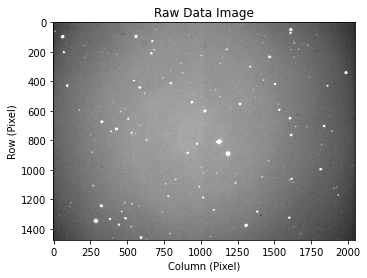

In [3]:
av_i = np.mean(image)
std_i = np.std(image)

plt.imshow(image, vmin=av_i-std_i, vmax=av_i+std_i, cmap='gray')
plt.title("Raw Data Image")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')

In [4]:
bias_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 1476 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2025-03-01T17:37:13' / Date FITS file was generated                  
IRAF-TLM= '2025-03-01T17:37:16' / Time of last modification                     
OBJECT  = 'zero    '           / Name of the object observed                    
CCDSUM  = '2 2     '           / CCD pixel summing                              
CCDBIN1 =                    2 / Binning factor along axis 1                    
CCDBIN2 =                   

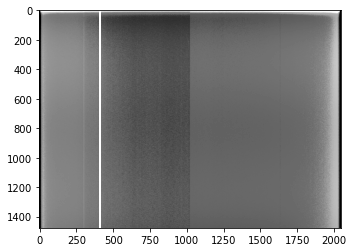

In [5]:
plt.imshow(bias, vmin=0, vmax=3,cmap='gray')

In [6]:
flat_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 1476 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2025-03-01T17:37:14' / Date FITS file was generated                  
IRAF-TLM= '2025-03-03T23:04:23' / Time of last modification                     
OBJECT  = '5s R dflat @ 43 %'  / Name of the object observed                    
CCDSUM  = '2 2     '           / CCD pixel summing                              
CCDBIN1 =                    2 / Binning factor along axis 1                    
CCDBIN2 =                   

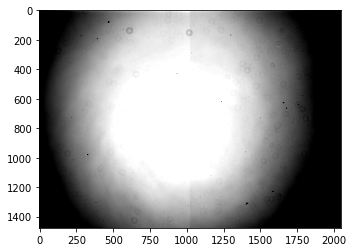

In [7]:
av_f = np.mean(flat)
std_f = np.std(flat)

plt.imshow(flat, vmin=av_f-std_f, vmax=av_f+std_f,cmap='gray')

Text(0, 0.5, 'Row (Pixel)')

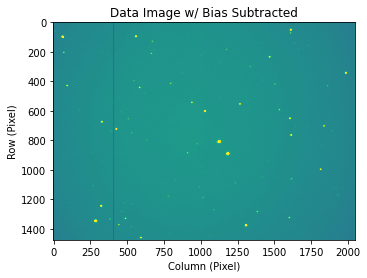

In [8]:
av_b = np.mean(image-bias)
std_b = np.mean(image-bias)

plt.imshow(image-bias, vmin=av_b-std_b,vmax=av_b+std_b)
plt.title("Data Image w/ Bias Subtracted")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')

In [9]:
def open_data(fits_num):
    filename = f'HD/hd265435.{fits_num}.fits'
    hdul = fits.open(filename)[0]
    data = hdul.data
    header = hdul.header
    return data

def subtract_bias(num):
    data = open_data(num)
    hdul = fits.open('HD/bias.fits')[0]
    bias = hdul.data
    sub_image = data - bias
    return sub_image

def flat(num):
    data = subtract_bias(num)
    hdul = fits.open('HD/rflat.fits')[0]
    flat = hdul.data
    for i in range(1476):
        for j in range(2048):
            if flat[i][j] == 0:
                flat[i][j] = 1e-6
    return data/flat

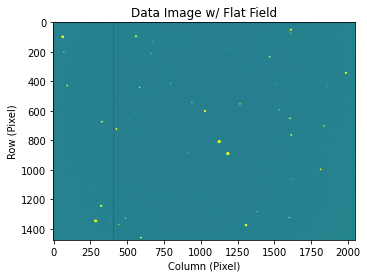

In [10]:
n = '0001'

av_f2 = np.mean(flat(n))
std_f2 = np.mean(flat(n))

plt.imshow(flat(n), vmin=av_f2-std_f2, vmax=av_f2+std_f2)
plt.title("Data Image w/ Flat Field")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')

im = flat(n)

In [11]:
np.interp(412, np.arange(0,2048), im[1,:])

207.1844024658203

In [12]:
subtract_bias('0004')[3,2045]

165.77866

In [13]:
for j in range(1476):
    im[j, 411] = np.interp(412, np.arange(0,2048), im[j,:])

Text(0, 0.5, 'Row (Pixel)')

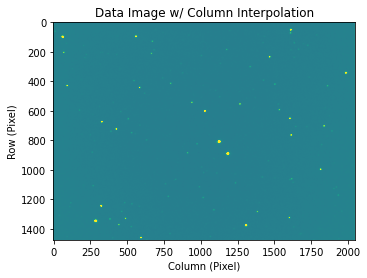

In [14]:
av_im = np.mean(im)
std_im = np.mean(im)

plt.imshow(im, vmin = av_im-std_im, vmax=av_im+std_im)
plt.title("Data Image w/ Column Interpolation")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')

In [15]:
def column_interp(num):
    im = flat(num)
    for j in range(1476):
        im[j, 411] = np.interp(412, np.arange(0,2048), im[j,:])
        im[j, 2044] = np.interp(2043, np.arange(0,2048), im[j,:])
        im[j, 2045] = np.interp(2043, np.arange(0,2048), im[j,:])
        im[j, 2046] = np.interp(2043, np.arange(0,2048), im[j,:])
        im[j, 2047] = np.interp(2043, np.arange(0,2048), im[j,:])
        im[j, 0] = np.interp(4, np.arange(0,2048), im[j,:])
        im[j, 1] = np.interp(4, np.arange(0,2048), im[j,:])
        im[j, 2] = np.interp(4, np.arange(0,2048), im[j,:])
        im[j, 3] = np.interp(4, np.arange(0,2048), im[j,:])
    for k in range(2048):
        im[0, k] = np.interp(1, np.arange(0,1476), im[:,k])
    return im

195.93463

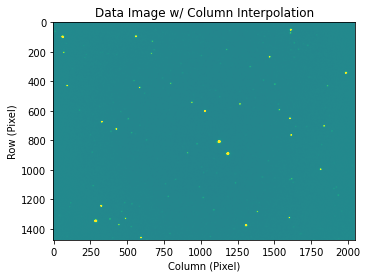

In [16]:
im = column_interp('0001')

av_im1 = np.mean(im)
std_im1 = np.mean(im)

plt.imshow(im, vmin = av_im1-std_im1, vmax = av_im1+std_im)
plt.title("Data Image w/ Column Interpolation")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')
im[0,0]

Text(0, 0.5, 'Row (Pixel)')

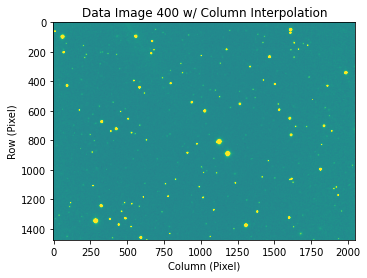

In [17]:
im2 = column_interp('0400')

av_im2 = np.mean(im2)
std_im2 = np.mean(im2)

plt.imshow(im2, vmin = av_im2-std_im2, vmax = av_im2+std_im2)

plt.title("Data Image 400 w/ Column Interpolation")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')

In [18]:
positions = [(62.36, 103.57), (1985.44, 340.00), (1126.00, 810.00), (1184.19, 891.18), (290.99, 1348.79), (1310.03, 1375.83)]

radii = [20]

apertures = [CircularAperture(positions, r=r) for r in radii]

phot_table = aperture_photometry(im, apertures)

header = []
for col in phot_table.colnames:

    phot_table[col].info.format = '%.8g'  # for consistent table output
    header = np.append(header,col)

# save the output for next notebook
f = open('photometry_project.csv', 'w')

writer = csv.writer(f)
writer.writerow(header)

for i in range(0,len(phot_table)):
    writer.writerow(phot_table[i])

f.close()

Text(0, 0.5, 'Row (Pixel)')

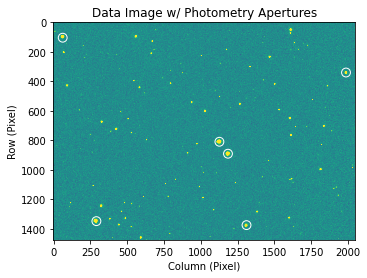

In [19]:
plt.imshow(im2,interpolation='nearest',vmin = av_im2-2*std_im2, vmax = av_im2+2*std_im2)
aperture = CircularAperture(positions, r=30) # in github, aperture size is r=20, but for some reason, here in Jupyter it barely surrounded the stars
ann_patches = aperture.plot(color='white',lw=1)

plt.title("Data Image w/ Photometry Apertures")
plt.xlabel('Column (Pixel)')
plt.ylabel('Row (Pixel)')

In [20]:
print(phot_table)


 id xcenter ycenter aperture_sum_0
      pix     pix                 
--- ------- ------- --------------
  1   62.36  103.57      507751.47
  2 1985.44     340      389480.01
  3    1126     810      772750.97
  4 1184.19  891.18      827638.38
  5  290.99 1348.79      779820.63
  6 1310.03 1375.83      448705.55


In [21]:
print(phot_table[2])

 id xcenter ycenter aperture_sum_0
      pix     pix                 
--- ------- ------- --------------
  3    1126     810      772750.97


[20]
[1.]


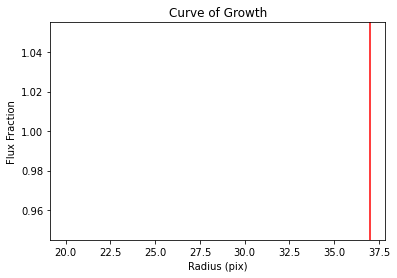

In [22]:
last = len(phot_table.columns)

column = []

for j in range(0,len(phot_table)):
    column.append([])
    for i in range(3,last):
        column[-1].append(phot_table[j][i]/phot_table[j][last-1])

df = pd.DataFrame(column)        

ap_frac = []
for i in range(3,last):
    ap_frac = np.append(ap_frac,df[i-3].mean())

plt.plot(radii,ap_frac)  
plt.xlabel('Radius (pix)')
plt.ylabel('Flux Fraction')
plt.title('Curve of Growth')
plt.axvline(37, c='r')
print(radii)
print(ap_frac)
#print(f'At a radius of {radii[6]}, the flux fraction is approximately {ap_frac[6]}')

In [23]:
ref_im = column_interp('0009')

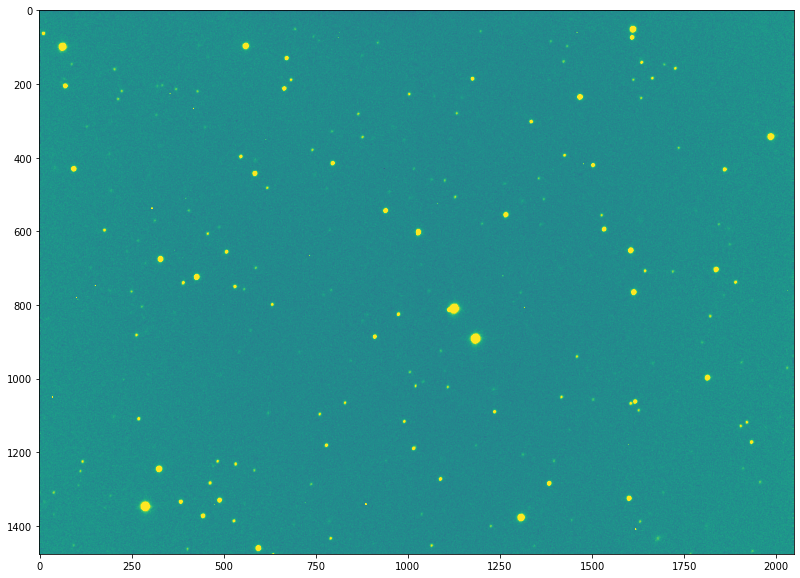

In [24]:
av = np.mean(ref_im)
std = np.std(ref_im)

fig, ax = plt.subplots(figsize=(30,10))
plt.imshow(ref_im, vmin=av-std, vmax=av+std)

Text(0, 0.5, 'Row')

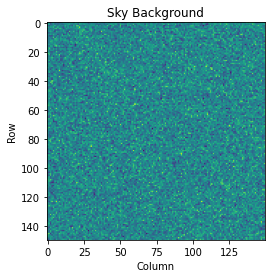

In [25]:
sky = ref_im[850:1000,1300:1450]
plt.imshow(sky)
plt.title("Sky Background")
plt.xlabel('Column')
plt.ylabel('Row')


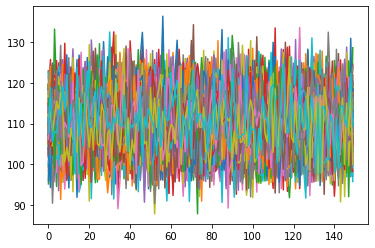

In [26]:
plt.plot(sky)

In [27]:
def flux(image, sky_mean):

    star_positions = [
        (62.36, 103.57),
        (1985.44, 340.00),
        (1126.00, 810.00),  
        (1184.19, 891.18),
        (290.99, 1348.79),
        (1310.03, 1375.83)
    ]

    aperture = CircularAperture(star_positions, r=20)
    data = aperture_photometry(image, aperture)

    print(data)

    return data

In [28]:
data = pd.read_csv('sample_photometry.csv', sep = ',')

(data[:]['Star1_Flux'] + data[:]['Star2_Flux'])/2

0    155300.481859
1    155393.678208
2    156746.037376
dtype: float64

In [29]:
def read_csv_phot(file):
    data = pd.read_csv(file, sep = ',')
    time = np.array(data[:]['HJD'])
    time = (time - min(time)) * 86400
    flux = np.array(data[:]['Star3_Flux'])
    mean_ref_flux = np.array((data[:]['Star1_Flux'] + data[:]['Star2_Flux'] + data[:]['Star4_Flux'] + data[:]['Star5_Flux'] + data[:]['Star6_Flux']) / 5)
    sigma = np.array(np.sqrt(data[:]['Star3_Flux']) + np.sqrt(np.pi*(400)*(data[:]['Sky_Mean'] + ((data[:]['Read_Noise1'] + data[:]['Read_Noise2']) / 2)**2)))
    return time, np.array(flux), np.array(sigma/mean_ref_flux), np.array(flux/mean_ref_flux)


In [30]:
time, flux_true, sigma, flux_rel = read_csv_phot('photometry (2).csv')


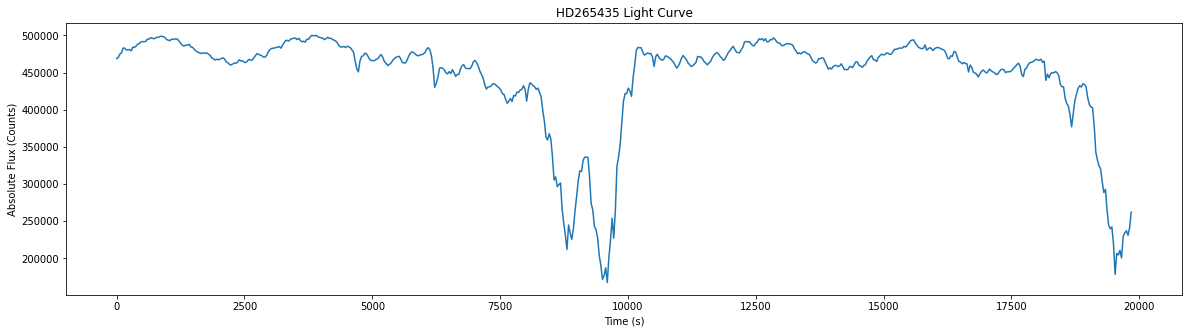

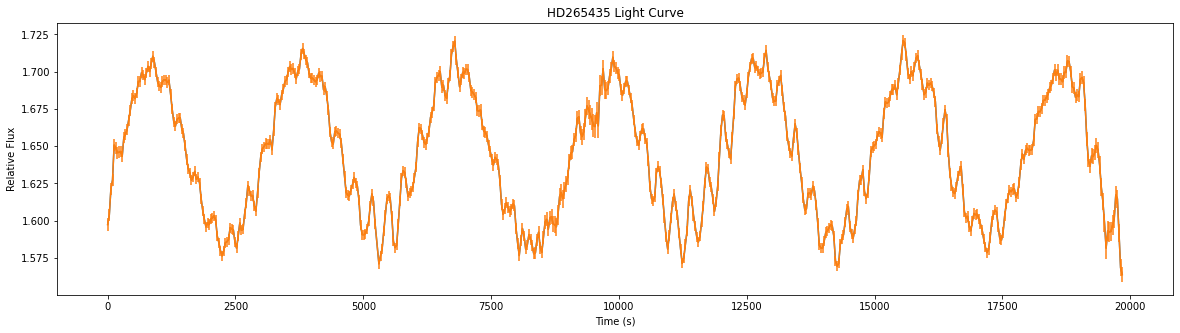

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(time, flux_true)
plt.xlabel('Time (s)')
plt.ylabel('Absolute Flux (Counts)')
plt.title('HD265435 Light Curve')
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(time, flux_rel)
plt.xlabel('Time (s)')
plt.ylabel('Relative Flux')
plt.title('HD265435 Light Curve')
plt.errorbar(time, flux_rel, sigma)
plt.savefig('lightcurve.png')

def phase_fold(time, flux, period):
    phases = time % period
    return phases, flux


5919.3478132104865
[   0.           31.57749921   63.12470287   94.6520716   126.16906017
  157.74740428  189.33439851  220.89198232  252.50919163  284.04694051
  315.60367942  347.1811384   378.62816155  410.2047354   441.6629836
  473.24997783  504.79722172  536.32455021  567.74131805  599.32915717
  630.9169963   662.47462034  694.07110959  725.57856292  757.06706643
  788.69377077  820.21164447  851.62841231  883.15578103  914.70298469
  946.13097757  977.63762623 1009.23496038 1040.72257876 1072.22918719
 1103.76693606 1135.20530909 1166.67216718 1198.10881019 1229.5765534
 1261.00370139 1292.5612852  1324.14912432 1355.56677729 1387.14339137
 1418.73034537 1450.28796941 1481.88530356 1513.4230122  1544.83028501
 1576.35765374 1607.78564662 1639.21190947 1670.79025358 1702.34699249
 1733.82511586 1765.35248458 1796.90918326 1828.3467114  1859.82394964
 1891.25194252 1922.70846069 1954.25570458 1985.7026875  2017.27069169
 2048.7678051  2080.22516817 2111.72228158 2143.20040494 217

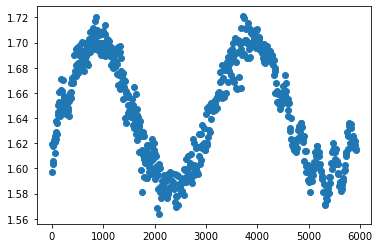

In [32]:
phase, flux = phase_fold(time, flux_rel, 2961.26*2)

print(max(phase))
plt.scatter(phase, flux)
print(phase)

phase_av = []
flux_av = []

for i in range(0, 5920, 15):
    phase_av.append(i)
    sum = 0
    n = 0
    for j in range(len(phase)):
        if i - 15 <= phase[j] <= i + 15:
            sum += flux[j]
            n += 1
    flux_av.append(sum/n)

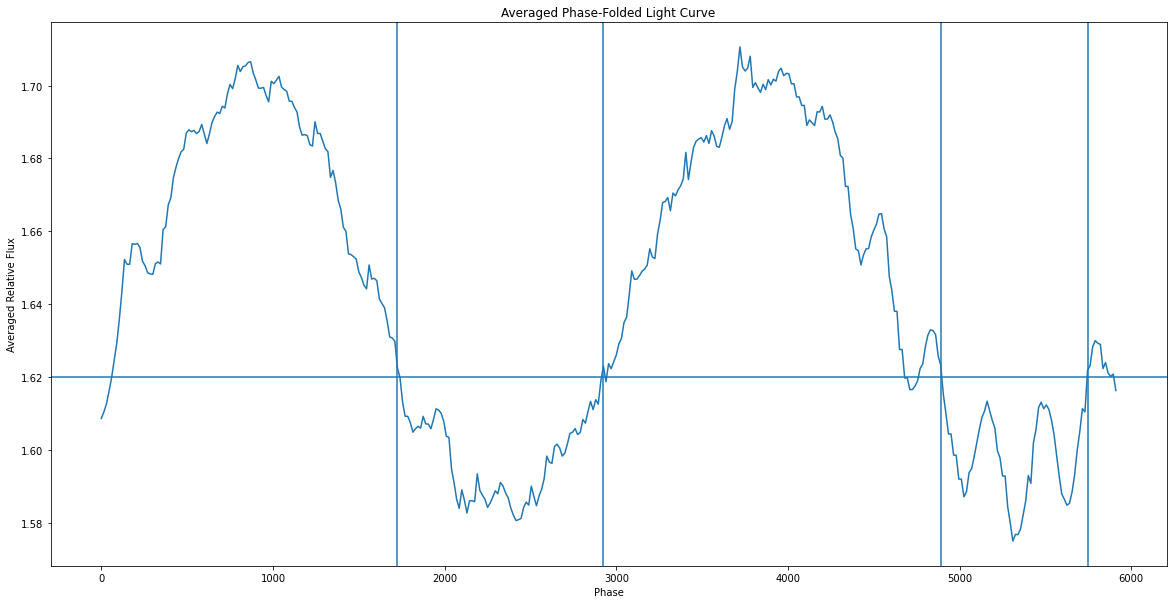

In [33]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(phase_av, flux_av)
plt.title('Averaged Phase-Folded Light Curve')
plt.xlabel('Phase')
plt.ylabel('Averaged Relative Flux')
plt.axvline(phase_av[115])
plt.axvline(phase_av[195])
plt.axhline(1.62)
plt.axvline(phase_av[326])
plt.axvline(phase_av[383])

In [34]:
dip1 = np.mean(flux_av[115:195])
dip2 = np.mean(flux_av[326:383])

print(dip1)
print(dip2)


1.5976635296966506
1.5981604513753784


In [35]:
def run_fft(time, flux):
    # First, subtract the mean to remove DC offset
    flux = flux - np.mean(flux)
    
    # How many data points
    N = len(time)
    
    # Time spacing (assume evenly spaced, otherwise use Lomb-Scargle)
    dt = np.median(np.diff(time))  # seconds

    # Compute FFT
    yf = np.fft.fft(flux)
    xf = np.fft.fftfreq(N, dt)  # frequencies in Hz

    # Only keep positive frequencies
    idx = np.where(xf > 0)

    xf = xf[idx]
    power = np.abs(yf[idx])**2  # Power Spectrum

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(xf, power)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('FFT Power Spectrum of HD265435')
    plt.grid(True)
    plt.show()
    plt.savefig(f'FT2.png')

    # Get indices of top 2 peaks
    sorted_indices = np.argsort(power)[::-1]
    top_freqs = xf[sorted_indices[:2]]
    top_periods = 1 / top_freqs

    print("Top 2 frequencies and periods:")
    for i in range(2):
        print(f"Peak {i+1}: Frequency = {top_freqs[i]:.6f} Hz, Period = {top_periods[i]:.2f} s")

    return xf, power


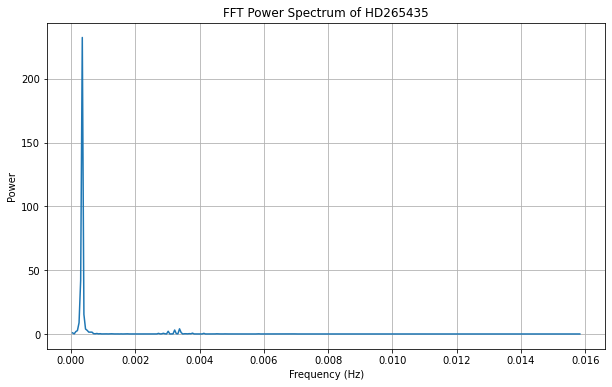

Top 2 frequencies and periods:
Peak 1: Frequency = 0.000353 Hz, Period = 2833.89 s
Peak 2: Frequency = 0.000302 Hz, Period = 3306.21 s


<Figure size 432x288 with 0 Axes>

In [36]:
xf, power = run_fft(time, flux_rel)

Results used for Orbital Frequency: 0.000353Hz

In [37]:
print(1/0.003378)


296.0331557134399


In [38]:
def sine_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

def fit_sine_wave(time, flux, freq_guess):
    # Initial guesses: Amplitude, frequency, phase, offset
    A_guess = (np.max(flux) - np.min(flux)) / 2
    phi_guess = 0
    C_guess = np.mean(flux)
    popt, pcov = curve_fit(sine_model, time, flux, p0=[A_guess, freq_guess, phi_guess, C_guess])
    
    A_fit, f_fit, phi_fit, C_fit = popt
    print(f"Best-fit parameters:\nAmplitude = {A_fit:.4f}\nFrequency = {f_fit:.6f} Hz\nPeriod = {1/f_fit:.2f} s\nPhase = {phi_fit:.2f}\nOffset = {C_fit:.4f}")

    # Generate model curve
    model_flux = sine_model(time, *popt)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.errorbar(time, flux, fmt='o', label='Data', alpha=0.5)
    plt.plot(time, model_flux, 'r-', label='Sine Fit', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Relative Flux')
    plt.title('Sine Fit to Light Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return popt


Best-fit parameters:
Amplitude = 0.0567
Frequency = 0.000338 Hz
Period = 2961.26 s
Phase = -0.30
Offset = 1.6431


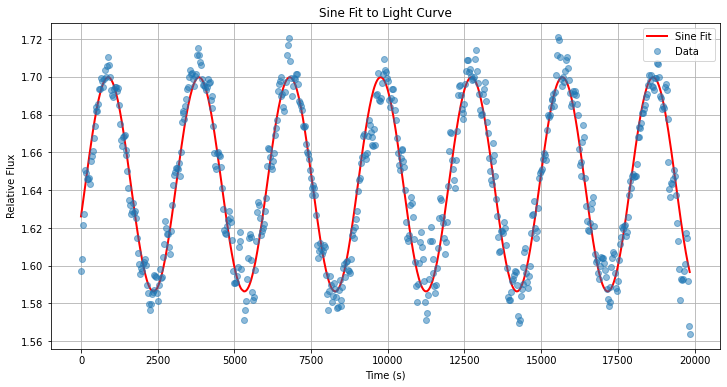

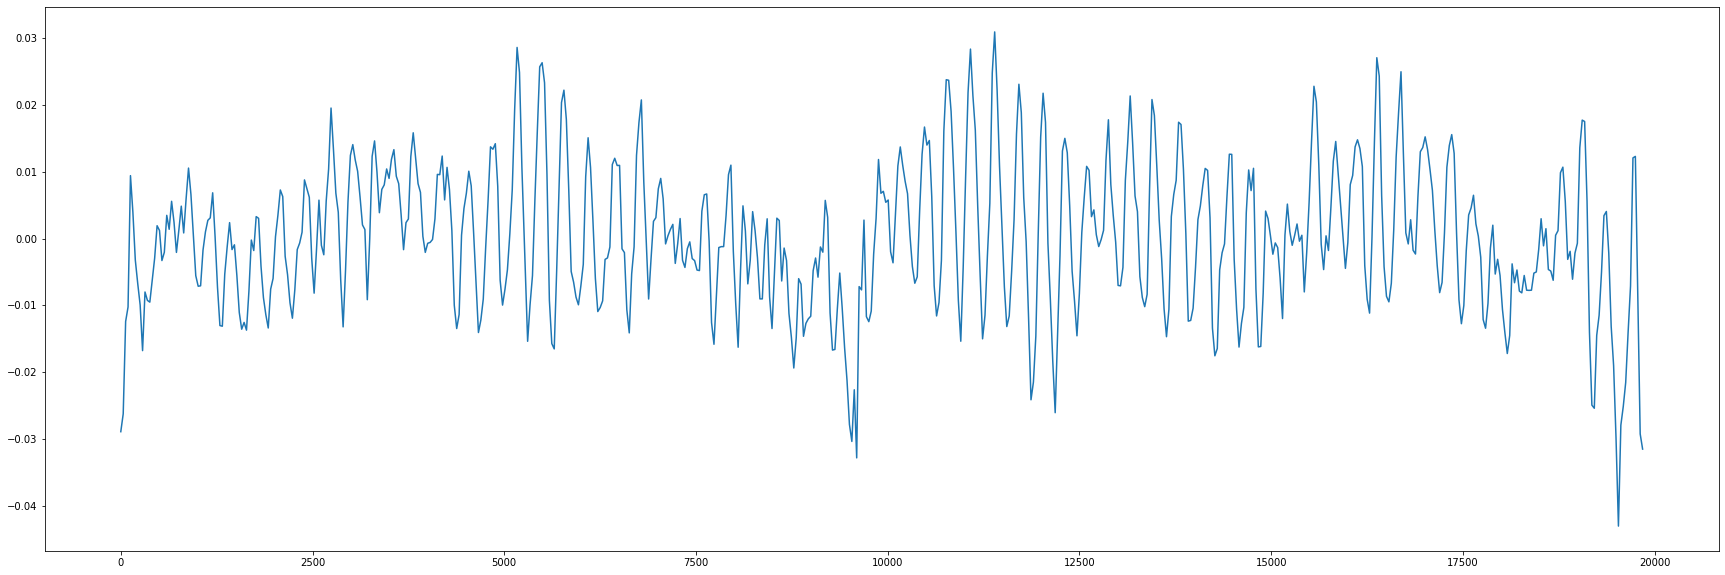

In [39]:
fit_sine_wave(time, flux, 0.000353)
fig, ax = plt.subplots(figsize=(30,10))
plt.plot(time, flux - sine_model(time, 0.0567, 0.000338, -0.30, 1.6431))

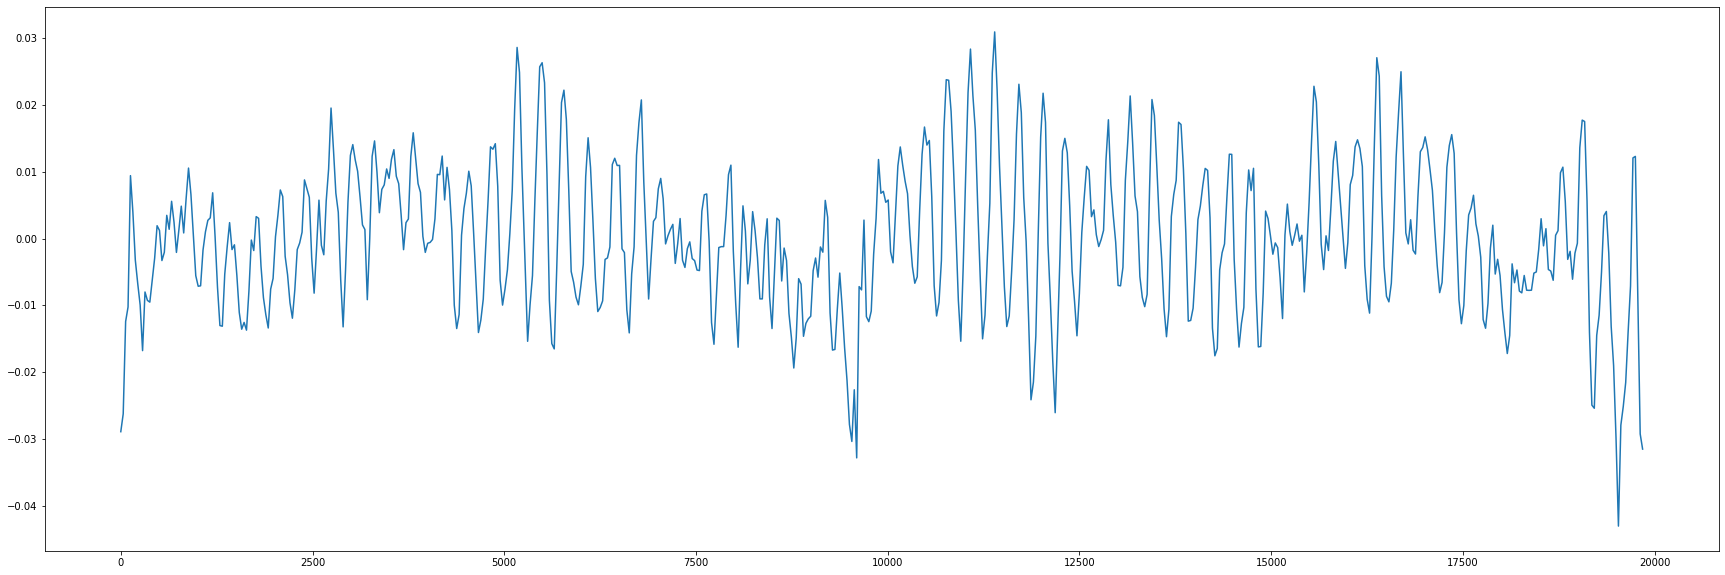

In [40]:
fig, ax = plt.subplots(figsize=(30,10))
plt.plot(time, flux - sine_model(time, 0.0567, 0.000338, -0.30, 1.6431))

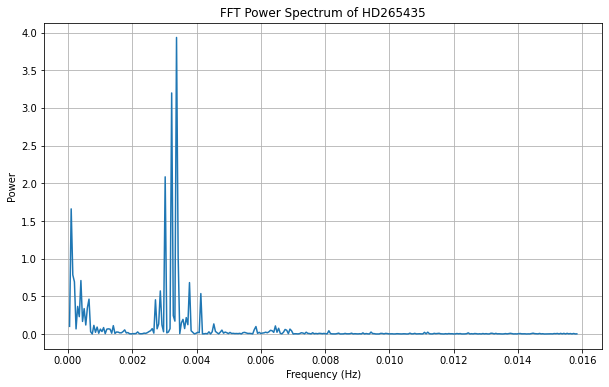

Top 2 frequencies and periods:
Peak 1: Frequency = 0.003377 Hz, Period = 296.08 s
Peak 2: Frequency = 0.003226 Hz, Period = 309.96 s


<Figure size 432x288 with 0 Axes>

In [41]:
x, y = run_fft(time, flux - sine_model(time, 0.0567, 0.000338, -0.30, 1.6431))


Results used for Pulsation Frequency: 0.003377Hz

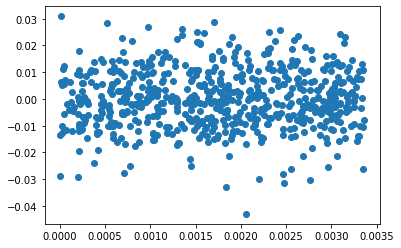

In [42]:
phase, flux = phase_fold(time, flux_rel - sine_model(time, 0.0567, 0.000338, -0.30, 1.6431), 0.003377)

plt.scatter(phase, flux)

# Code for finding Uncertainties

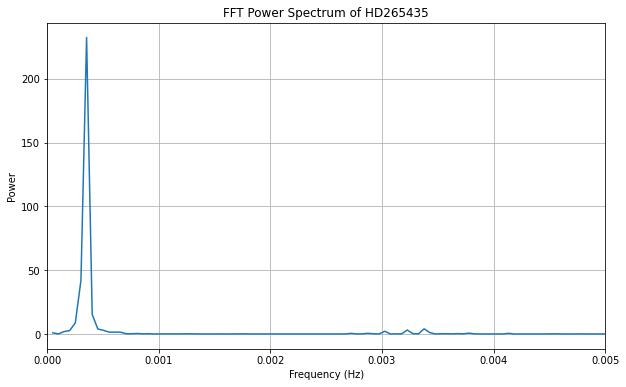

Top Frequency and period:
Frequency = 0.000353 Hz, Period = 2833.89 s
Peak Height: 232.46049471530836
Full-Width Half-Max Value: 116.23024735765418


In [43]:
# FFT function

def run_fft(time, flux):
    
    # calculate the number of time points
    N = len(time)
    
    # calculate the median time step
    dt = np.median(np.diff(time)) # seconds

    # compute the FFT
    yf = np.fft.fft(flux)
    xf = np.fft.fftfreq(N, dt)  # frequencies in Hz

    # only keep positive frequencies
    idx = np.where(xf > 0)
    xf = xf[idx]

    # calculate the power spectrum
    power = np.abs(yf[idx])**2

    return xf, power

# plot the FFT for our light curve

xf, power = run_fft(time, flux_rel)

plt.figure(figsize=(10,6))
plt.plot(xf, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum of HD265435')
plt.xlim(0,0.005)
plt.grid(True)
plt.show()

# find the max frequency and its power
sorted_indices = np.argsort(power)[::-1]
top_freqs = xf[sorted_indices[:1]]
peak_height = power[sorted_indices[:1]]

# calculate the max period
top_periods = 1 / top_freqs

# print the values
print("Top Frequency and period:")
print(f"Frequency = {top_freqs[0]:.6f} Hz, Period = {top_periods[0]:.2f} s")
print(f'Peak Height: {peak_height[0]}')
print(f'Full-Width Half-Max Value: {peak_height[0]/2}')

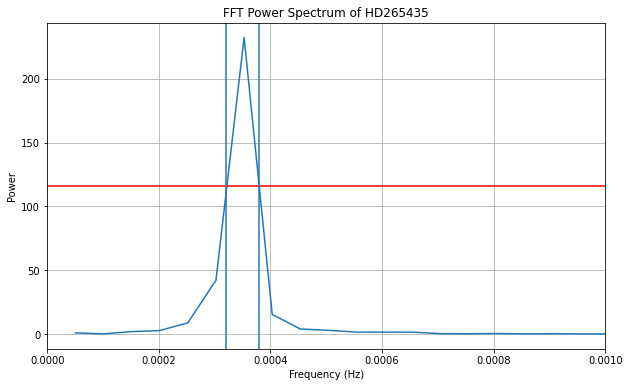

Uncertainty in Frequency: 2.9999999999999997e-05 Hz
Uncertainty in Period Side 1: 222.92394255874706 s
Uncertainty in Period Side 2: -262.0852321981424 s


In [44]:
# plot
plt.figure(figsize=(10,6))
plt.plot(xf, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum of HD265435')
plt.xlim(0,0.001)
plt.grid(True)

# full-width half-max value
plt.axhline(116.230247, c = 'r')

# intersect values
plt.axvline(0.00032)
plt.axvline(0.00038)

plt.show()

# calculate the uncertainty
print(f'Uncertainty in Frequency: {(0.00038 - 0.00032)/2} Hz')

# the period uncertainty is just the difference from the calculated period to the calculated periods at the uncertainty limits
print(f'Uncertainty in Period Side 1: {2833.89 - (1/(0.000353+0.00003))} s')
print(f'Uncertainty in Period Side 2: {2833.89 - (1/(0.000353-0.00003))} s')

In [45]:
# sine curve model

def sine_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# fit the sine curve to the data

def fit_sine_wave(time, flux, freq_guess):
    
    # calculate initial guesses for the parameters based on the system
    A_guess = (np.max(flux) - np.min(flux)) / 2
    phi_guess = 0
    C_guess = np.mean(flux)

    # fit the curve using the curve_fit model in scipy
    popt, pcov = curve_fit(sine_model, time, flux, p0=[A_guess, freq_guess, phi_guess, C_guess])

    # separate out the parameters, and state them
    A_fit, f_fit, phi_fit, C_fit = popt

    # find the uncertainty in each coefficient
    sigma_A = pcov[0,0]
    sigma_f = pcov[1,1]
    sigma_phi = pcov[2,2]
    sigma_C = pcov[3,3]
    sigma_p = (1/f_fit) - (1/(f_fit + sigma_f))
    print(f"Best-fit parameters:\nAmplitude = {A_fit:.4f} +/- {sigma_A}\nFrequency = {f_fit:.7f} +/- {sigma_f} Hz\nPeriod = {1/f_fit:.2f} +/- {sigma_p} s\nPhase = {phi_fit:.2f} +/- {sigma_phi}\nOffset = {C_fit:.4f} +/- {sigma_C}")

    return sine_model(time, A_fit, f_fit, phi_fit, C_fit)   
# Fit and get the model
sine_fit = fit_sine_wave(time, flux_rel, freq_guess=0.000353)

# Subtract the fitted sine wave from the original flux to get the residuals
subtracted_flux = flux_rel - sine_fit

Best-fit parameters:
Amplitude = 0.0567 +/- 3.8789593614809365e-07
Frequency = 0.0003377 +/- 8.604932792299863e-14 Hz
Period = 2961.26 +/- 7.54570010030875e-07 s
Phase = -0.30 +/- 0.00045153309992763854
Offset = 1.6431 +/- 1.9092731974825953e-07


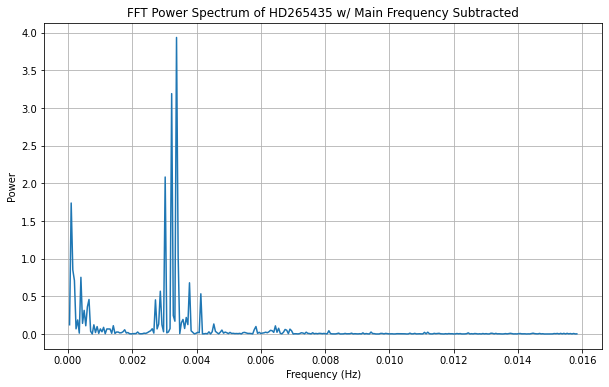

Top Frequency and period:
Frequency = 0.003377 Hz, Period = 296.08 s
Peak Height: 4.0463031187225456
Full-Width Half-Max Value: 2.0231515593612728


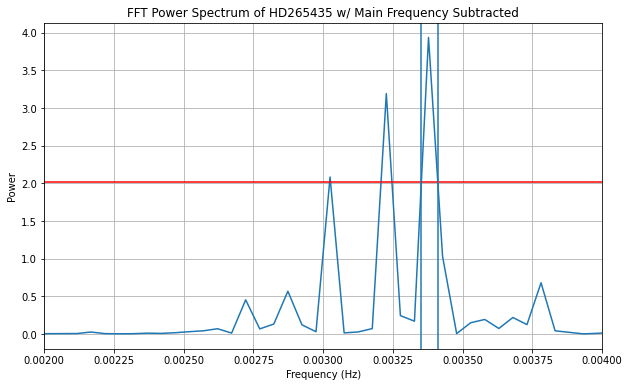

Uncertainty in Frequency: 2.9999999999999862e-05 Hz
Uncertainty in Period Side 1: 2.5666451423539343 s
Uncertainty in Period Side 2: -2.695022408126704 s
Uncertainty in Period Average: 2.6308 s


In [46]:
# plot the FFT for our subtracted light curve

xf_sub, power_sub = run_fft(time, subtracted_flux)

# Plot
plt.figure(figsize=(10,6))
plt.plot(xf_sub, power_sub)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum of HD265435 w/ Main Frequency Subtracted')
plt.grid(True)

plt.show()

sorted_indices = np.argsort(power_sub)[::-1]
top_freqs = xf[sorted_indices[:1]]
top_periods = 1 / top_freqs
peak_height = power[sorted_indices[:1]]

print("Top Frequency and period:")
print(f"Frequency = {top_freqs[0]:.6f} Hz, Period = {top_periods[0]:.2f} s")
print(f'Peak Height: {peak_height[0]}')
print(f'Full-Width Half-Max Value: {peak_height[0]/2}')

# plot the FFT
plt.figure(figsize=(10,6))
plt.plot(xf_sub, power_sub)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FFT Power Spectrum of HD265435 w/ Main Frequency Subtracted')
plt.grid(True)
plt.xlim(0.002,0.004)

# full-width half-max value
plt.axhline(2.02315, c='r')

# intersect values
plt.axvline(0.00335)
plt.axvline(0.00341)

plt.show()

# print the uncertainties
print(f'Uncertainty in Frequency: {(0.00341 - 0.00335)/2} Hz')
print(f'Uncertainty in Period Side 1: {296.08 - (1/(0.003377+0.00003))} s')
print(f'Uncertainty in Period Side 2: {296.08 - (1/(0.003377-0.00003))} s')
print(f'Uncertainty in Period Average: {(2.5666+2.6950)/2} s')

Dip 1 mean flux: 1.5976635296966506
Dip 2 mean flux: 1.5981573790718355
Uncertainty in Dip 1: 5.929572473380224e-05
Uncertainty in Dip 2: 0.00048229666040925143
Uncertainty in Depth Difference: 0.0004859280313108348


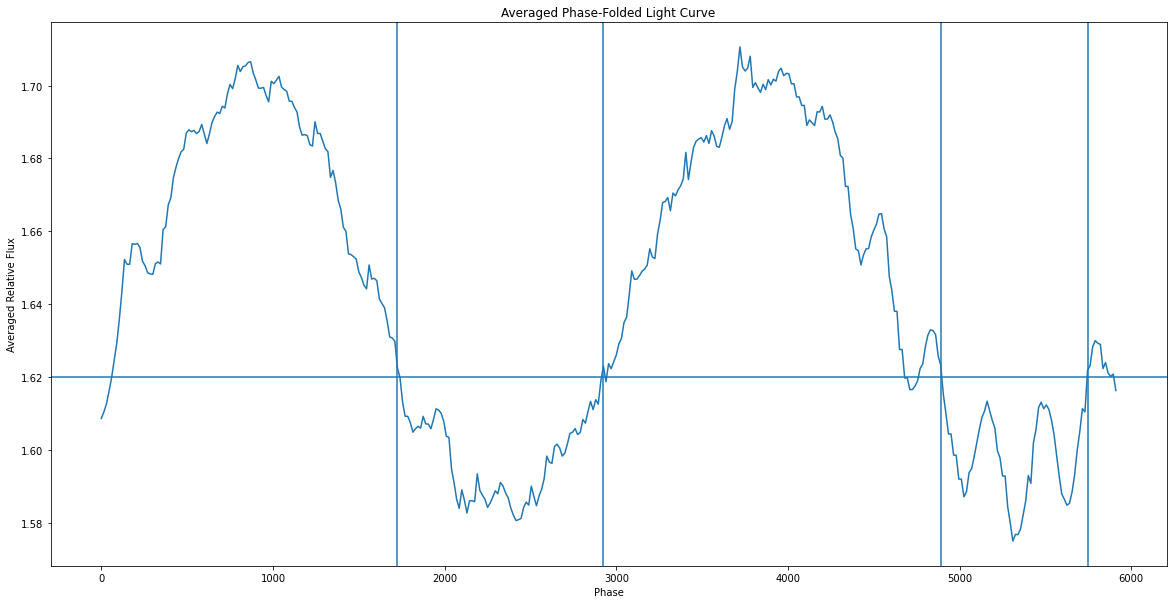

In [49]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(phase_av, flux_av)
plt.title('Averaged Phase-Folded Light Curve')
plt.xlabel('Phase')
plt.ylabel('Averaged Relative Flux')
plt.axvline(phase_av[115])
plt.axvline(phase_av[195])
plt.axhline(1.62)
plt.axvline(phase_av[326])
plt.axvline(phase_av[383])
    # Compute mean flux for the dips (same as in original code)
dip1 = np.mean(flux_av[115:195])  # Adjusted dip 1 region
dip2 = np.mean(flux_av[150:200])  # Adjusted dip 2 region

print(f"Dip 1 mean flux: {dip1}")
print(f"Dip 2 mean flux: {dip2}")

    # Calculate uncertainties in the dip regions
sigma_dip1 = np.sqrt(np.sum(np.array(sigma[115:195])**2)) / len(sigma[115:1195])
sigma_dip2 = np.sqrt(np.sum(np.array(sigma[150:200])**2)) / len(sigma[150:200])

print(f"Uncertainty in Dip 1: {sigma_dip1}")
print(f"Uncertainty in Dip 2: {sigma_dip2}")

    # Calculate the uncertainty in the difference between the dips
sigma_difference = np.sqrt(sigma_dip1**2 + sigma_dip2**2)
print(f"Uncertainty in Depth Difference: {sigma_difference}")
